In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")

import nidn
import torch

12:50:15|NIDN-INFO| Initialized NIDN for cpu
12:50:15|NIDN-INFO| Using double precision


## Uniform Titanium-Dixide Ground Truth

The following settings is used in order to compare the resulting spectrum to an experimentally measured for Titanium Dioxide, as found in this paper:  Wojcieszak, D., Kaczmarek, D. and Domaradzki, J.. "Analysis of surface properties of semiconducting (Ti,Pd,Eu)Ox thin films" Opto-Electronics Review, vol. 24, no. 1, 2016, pp. 15-19. https://doi.org/10.1515/oere-2016-0003
The wavelengths presented by the paper is between 300 nm and 900 nm, and the thickness is 380 nm. Thus the same settings are used here

In [2]:
cfg = nidn.load_default_cfg()
# Set the number of frequencies to simulate for
cfg.N_freq = 100
#Number of layers with materials
cfg.N_layers = 1
# Define the thickness of the layer to be 380 nm
cfg.PER_LAYER_THICKNESS=[0.38]
#Set wavelength range to be 300 nm to 900 nm
cfg.physical_wavelength_range[0]=3e-7
cfg.physical_wavelength_range[1]=9e-7
# Choose FDTD method, TRCWA other option
cfg.solver = "FDTD"
# Increasing number of grid points per unit magnitude to match actual thickness
cfg.FDTD_min_gridpoints_per_unit_magnitude = 50
# Set number of time steps in FDTD
cfg.FDTD_niter = 400
# Choose pulse type (continuous, hanning or ricker)
cfg.FDTD_pulse_type = 'continuous'
# Choose source type (line or point)
cfg.FDTD_source_type = 'line'
# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

In [3]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)

layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")

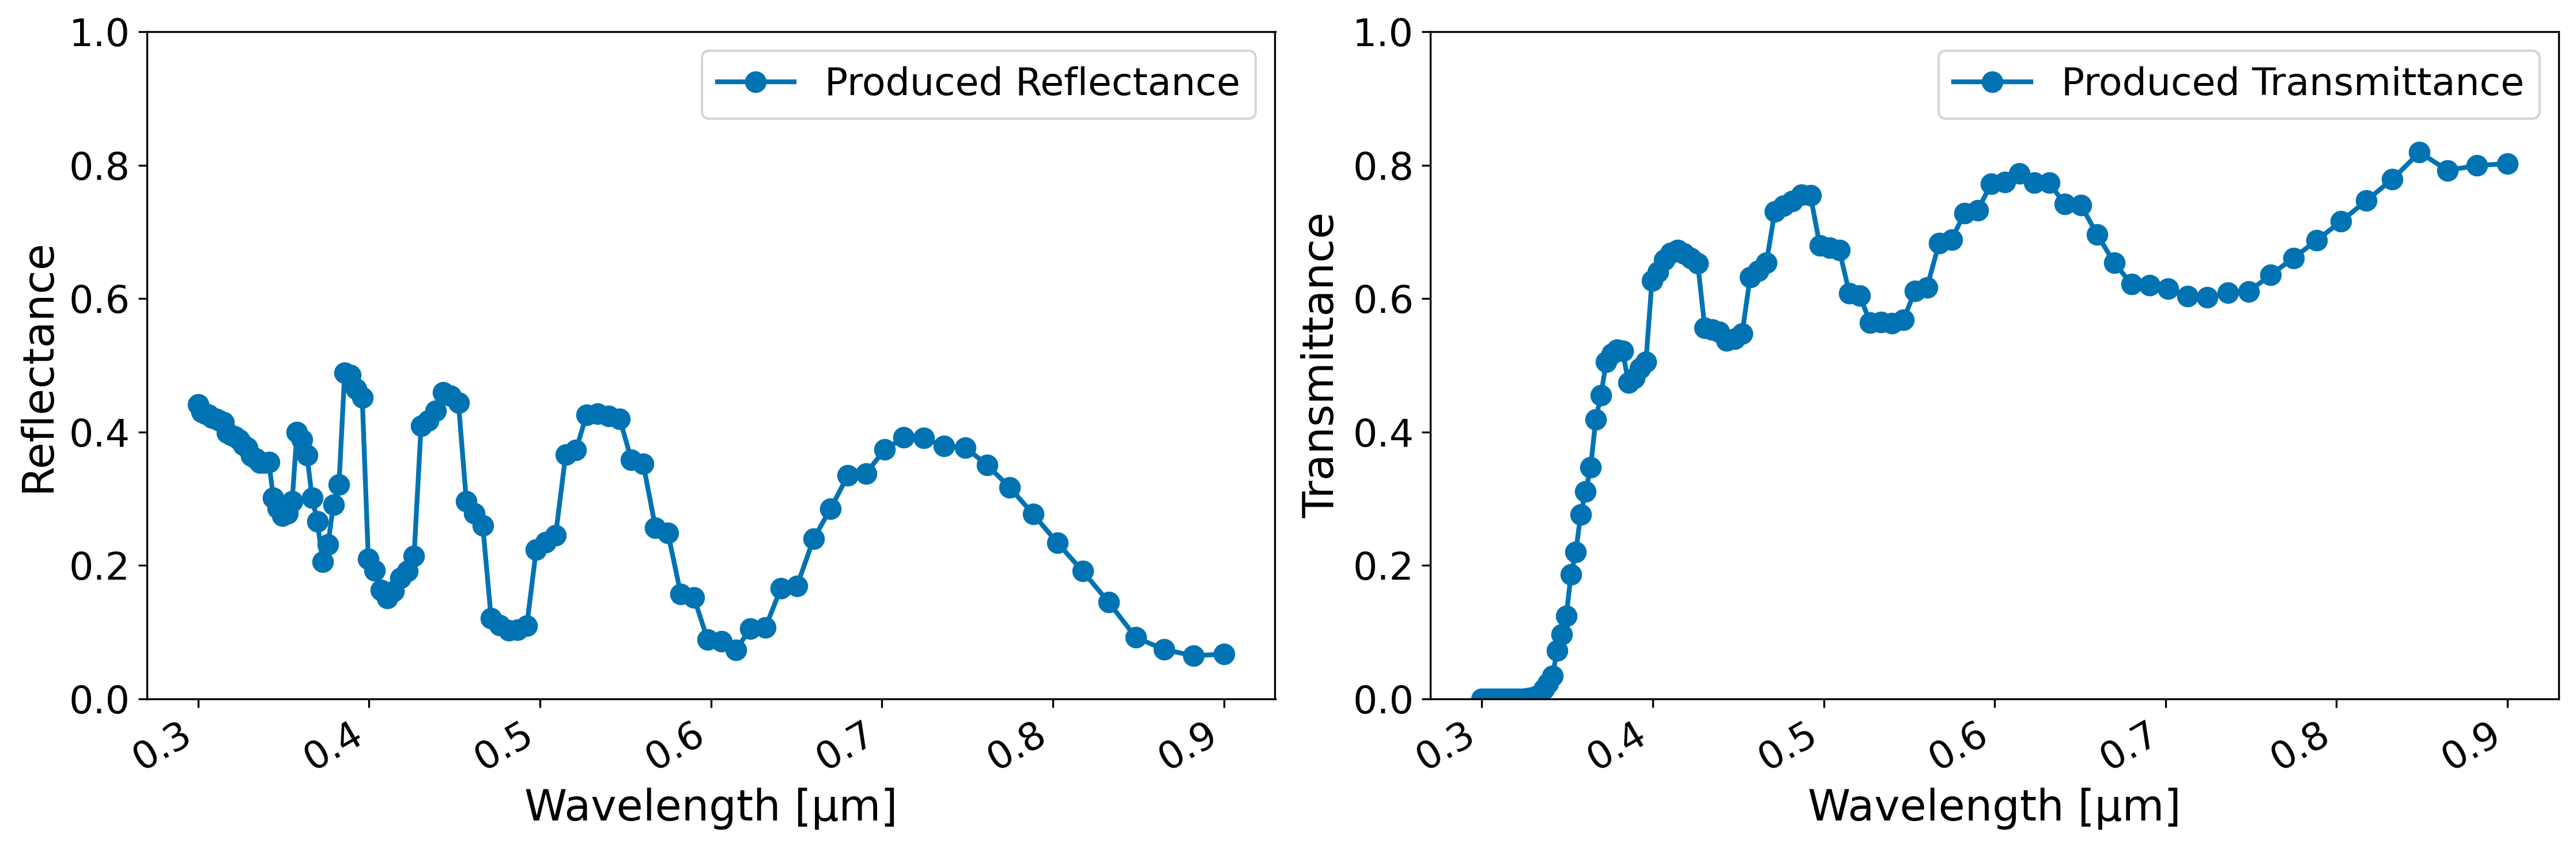

In [4]:
# Compute spectrum for this configuration
R,T = nidn.compute_spectrum(eps_grid,cfg)
nidn.plot_spectrum(cfg,R,T)

In [5]:
print("cfg.target_reflectance_spectrum = [", end="")
[print(f"{r.item():.8f}",end=",") for r in R]
print("]")
print("cfg.target_transmittance_spectrum = [",end="")
[print(f"{t.item():.8f}",end=",") for t in T]
print("]")

cfg.target_reflectance_spectrum = [0.06699784,0.06439643,0.07401415,0.09185526,0.14473437,0.19140313,0.23372247,0.27676050,0.31673123,0.35065916,0.37669063,0.37861258,0.39066959,0.39151593,0.37353388,0.33771078,0.33518054,0.28456823,0.23957478,0.16919446,0.16596154,0.10725505,0.10499476,0.07304930,0.08638410,0.08898159,0.15169660,0.15708895,0.24828848,0.25672907,0.35219554,0.35848523,0.41991411,0.42356950,0.42705627,0.42570102,0.37286900,0.36632883,0.24517115,0.23461795,0.22368560,0.10924185,0.10381090,0.10265405,0.11073049,0.12031053,0.25975040,0.27757625,0.29619244,0.44369878,0.45451676,0.45939356,0.43134026,0.41735261,0.40920525,0.21388176,0.19169069,0.18106829,0.16137611,0.15093119,0.16288675,0.19218703,0.20953451,0.45151409,0.46405849,0.48501661,0.48861637,0.32077495,0.29118600,0.23120399,0.20557749,0.26610176,0.30150528,0.36504455,0.38858774,0.39971664,0.29606522,0.27765355,0.27467029,0.28591726,0.30116080,0.35451021,0.35352400,0.35410239,0.35988304,0.36409468,0.37676575,0.381105

## Uniform Three-Layer Ground Truth 

In [ ]:
# Start with the default config
cfg = nidn.load_default_cfg()

# Set grid specifics
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 3
cfg.N_freq = 16
cfg.PER_LAYER_THICKNESS = [0.1]
cfg.FDTD_pulse_type = 'continuous'
cfg.freq_distribution = "linear"

# The wavelength range is set to cover visible light and also overlap with the smallest wavelength of TRCWA for comparison
cfg.physical_wavelength_range[0] = 8e-7 
cfg.physical_wavelength_range[1] = 1.5e-6

# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)
# Number of iterations is increased from previousl example due to a thicker layer which creates a longer path for the waves to travel trough. 
cfg.FDTD_niter = 400
cfg.solver ="FDTD"

In [ ]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)
layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")
eps_grid[:,:,1,:] = layer_builder.build_uniform_layer("germanium")
eps_grid[:,:,2,:] = layer_builder.build_uniform_layer("tantalum_pentoxide")

In [ ]:
# Compute spectrum for this configuration
R,T = nidn.compute_spectrum(eps_grid,cfg)
nidn.plot_spectrum(cfg,R,T)

In [ ]:
print("cfg.target_reflectance_spectrum = [", end="")
[print(f"{r.item():.8f}",end=",") for r in R]
print("]")
print("cfg.target_transmittance_spectrum = [",end="")
[print(f"{t.item():.8f}",end=",") for t in T]
print("]")

# Extract time signal for comparison

### Our implementation

In [6]:
from nidn.fdtd_integration.init_fdtd import init_fdtd
from nidn.fdtd_integration.compute_spectrum_fdtd import _get_detector_values
import matplotlib.pyplot as plt

In [7]:
cfg = nidn.load_default_cfg()
# Set the number of frequencies to simulate for
cfg.N_freq = 1
#Number of layers with materials
cfg.N_layers = 1
# Define the thickness of each layer
cfg.PER_LAYER_THICKNESS=[0.3]
#Smallest wavelength
cfg.physical_wavelength_range[0]=10e-7
#Largest wavelength
cfg.physical_wavelength_range[1]=10e-7
# Choose FDTD method, TRCWA other option
cfg.solver = "FDTD"
# Set number of time steps in FDTD
cfg.FDTD_niter = 400
# Choose pulse type (continuous, hanning or ricker)
cfg.FDTD_pulse_type = 'continuous'
# Choose source type (line or point)
cfg.FDTD_source_type = 'line'
# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

In [8]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)
layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 539.32it/s]


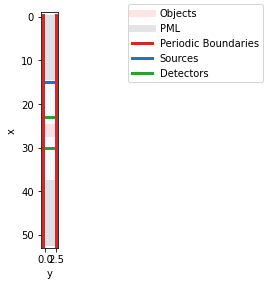

In [9]:
grid, t_detector_material, _  = init_fdtd(cfg,include_object = True, wavelength = cfg.physical_wavelength_range[0],permittivity = eps_grid[:,:,0,:])
plt.figure()
grid.visualize(z=0)
grid.run(cfg.FDTD_niter)

In [10]:
# Using only transmission signal for coparison
t_signal_material, r_ = _get_detector_values(t_detector_material,_)

### Original FDTD

In [11]:
import fdtd
from nidn.utils.global_constants import EPS_0, PI

fdtd.set_backend("torch")

SPEED_LIGHT: float = 299_792_458.0 
TIMESTEPS = 400

Set up the grid in the same way

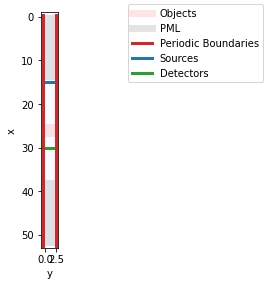

In [12]:
# create FDTD Grid
grid_spacing = 0.1 * cfg.physical_wavelength_range[0]
grid = fdtd.Grid(
    (5.3e-6,3, 1),  # 2D grid
    grid_spacing=grid_spacing,
    permittivity=1.0,  # Relative permittivity of 1  vacuum
)

# sources
grid[int(1.5e-6/grid_spacing), :] = fdtd.LineSource(period=cfg.physical_wavelength_range[0] / SPEED_LIGHT, name="source")

# detectors
t_detector_material = fdtd.LineDetector(name="detector")
grid[int(2.8e-6/grid_spacing)+2, :, 0] = t_detector_material

# x boundaries
grid[0:int(1.5e-6/grid_spacing), :, :] = fdtd.PML(name="pml_xlow")
grid[-int(1.5e-6/grid_spacing):, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")

# The absorbing object fills the whole grid
grid[int(2.5e-6/grid_spacing):int(2.8e-6/grid_spacing),:, :] = fdtd.AbsorbingObject(
    permittivity=eps_grid[:,:,0,0].real, conductivity=eps_grid[:,:,0,0].imag*SPEED_LIGHT/cfg.physical_wavelength_range[0]*2*PI*EPS_0, name="absorbin_object"
)
plt.figure()
grid.visualize(z=0)

Run the simulation

In [13]:
grid.run(TIMESTEPS, progress_bar= False)

Extract time domain signal from  transmission detector

In [14]:
raw_signal = []
t = []
for i in range(TIMESTEPS):
    #Add only the z component of the E field from the center point of the detector, as there is only z polarized waves
    raw_signal.append(t_detector_material.detector_values()['E'][i][1][2])
    t.append(i)
#raw_signal, r_ = _get_detector_values(t_detector_material,t_detector_material)

Plot the signal through the material for both cases, to see that thay match

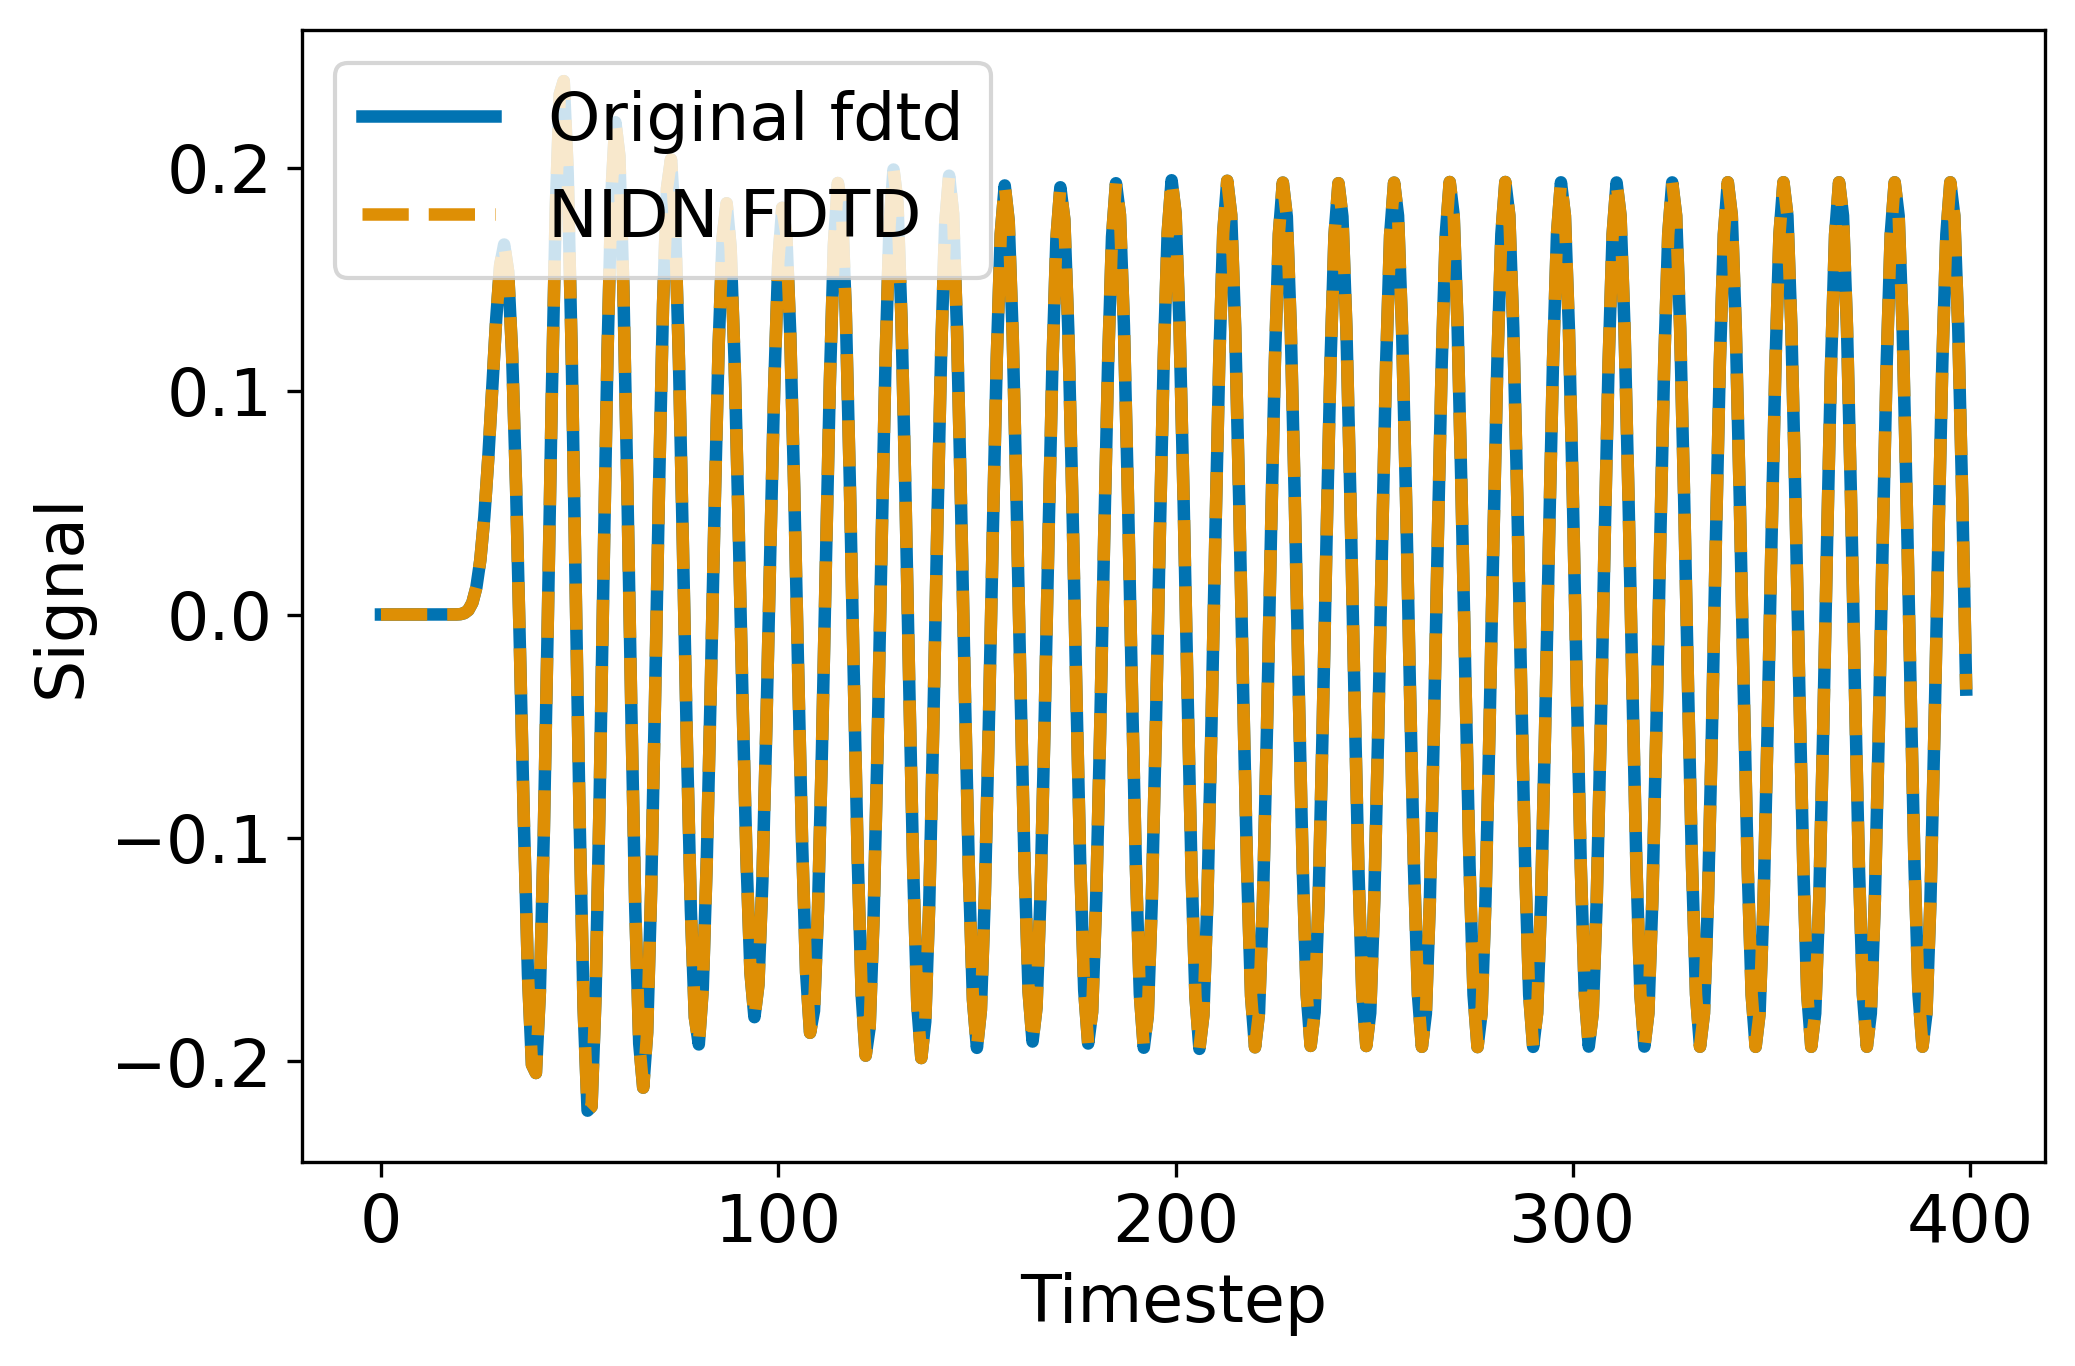

In [15]:
from nidn.utils.global_constants import NIDN_PLOT_COLOR_1,NIDN_PLOT_COLOR_2,NIDN_FONTSIZE
plt.figure(figsize=(7.5,5.0),dpi=300)
plt.plot(t,raw_signal,NIDN_PLOT_COLOR_1,lw=3)
plt.plot(t,t_signal_material,NIDN_PLOT_COLOR_2,lw=3,linestyle="--")
plt.legend(["Original fdtd", "NIDN FDTD"],fontsize=NIDN_FONTSIZE)
plt.ylabel("Signal",fontsize=NIDN_FONTSIZE)
plt.xlabel("Timestep",fontsize=NIDN_FONTSIZE)
plt.tick_params(axis="both", which="major", labelsize=NIDN_FONTSIZE)

Since the two signals are non-distinguishable, we plot the relative error

Text(0.5, 0, 'Timestep')

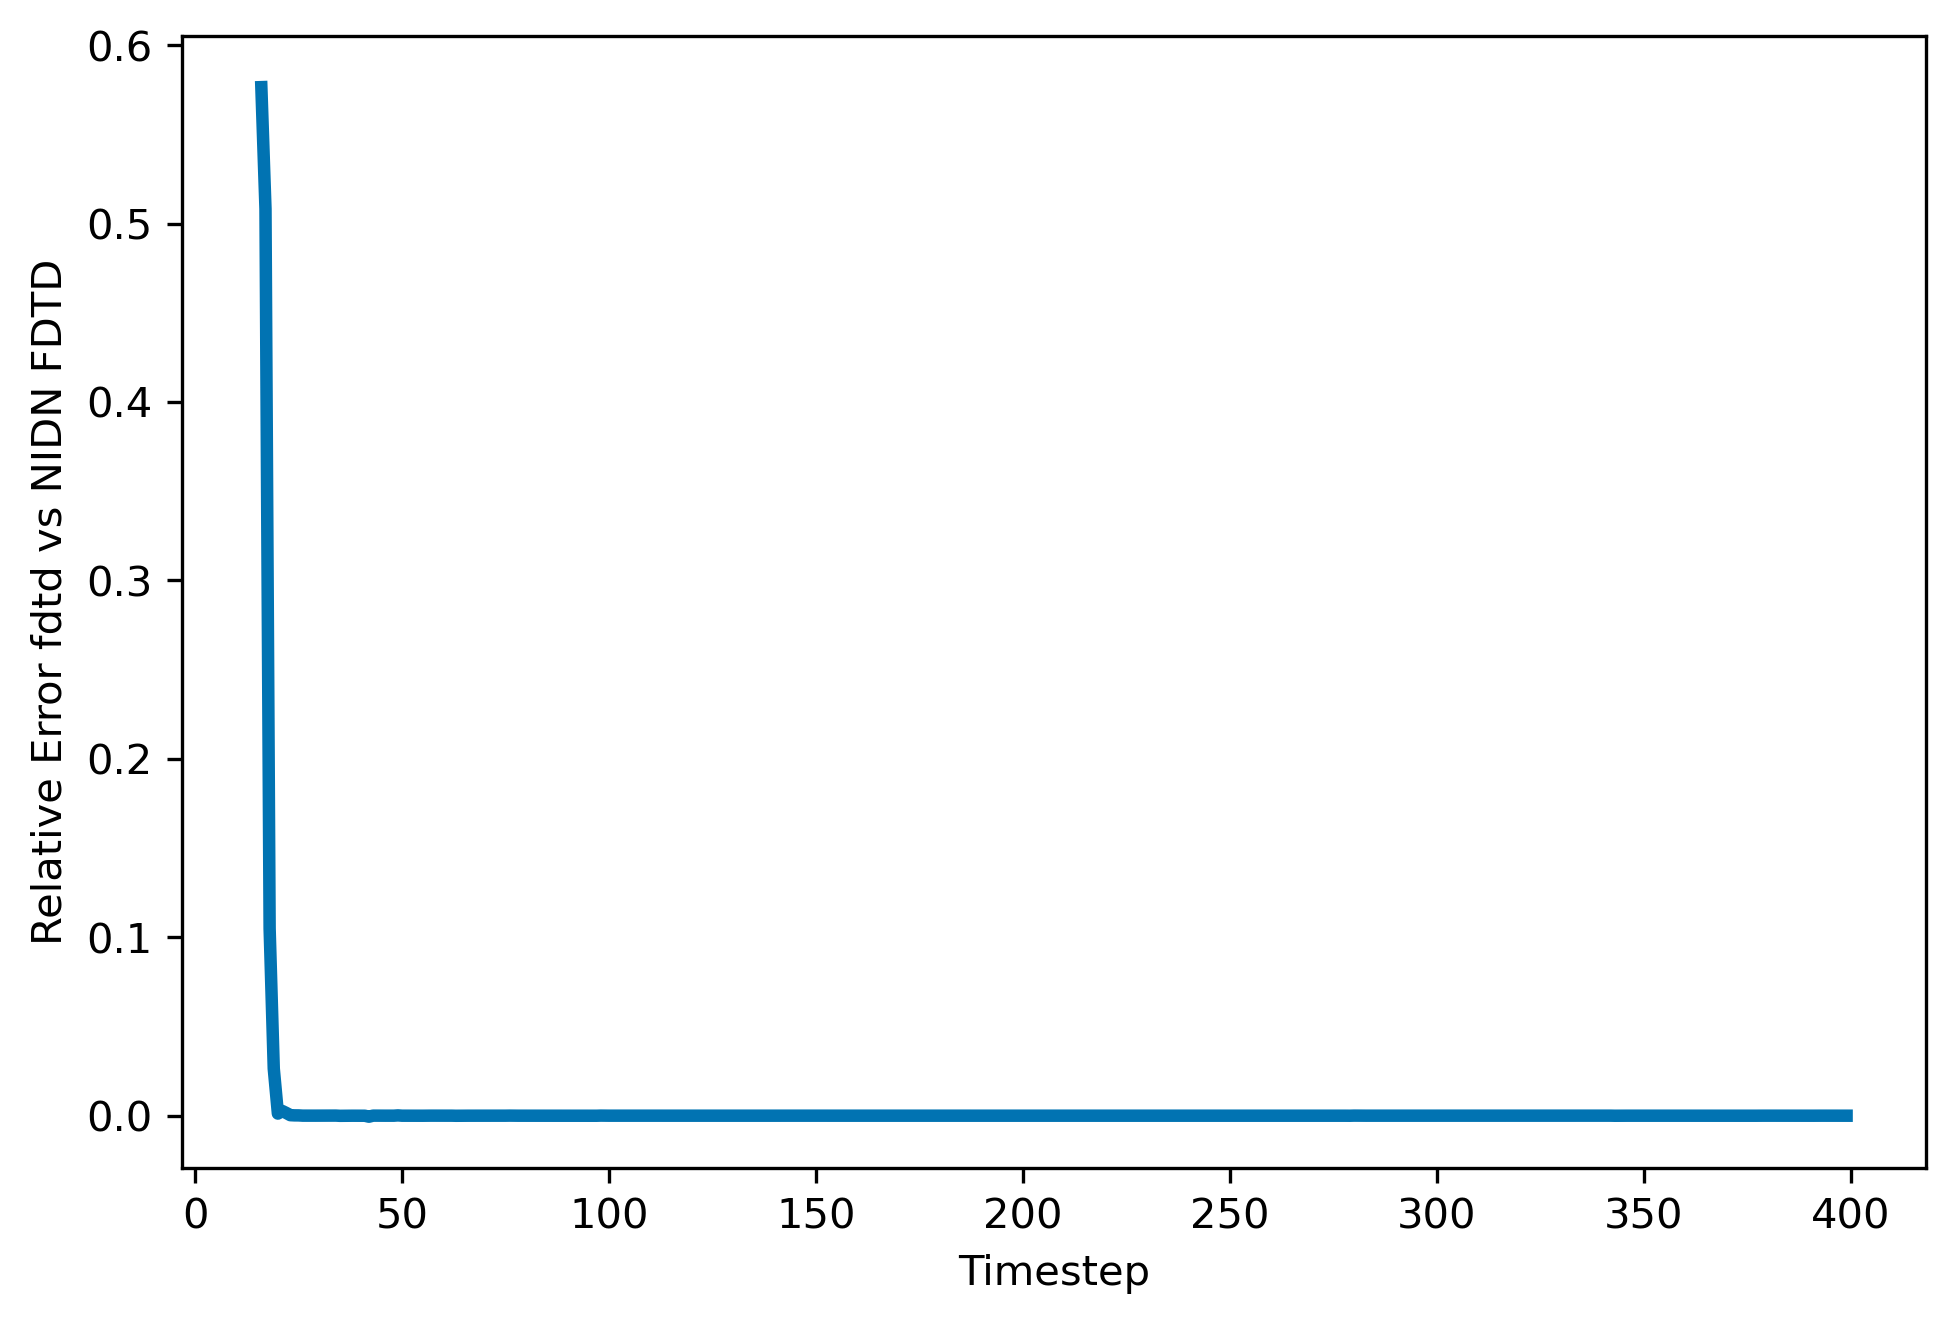

In [16]:
plt.figure(figsize=(7.5,5.0),dpi=300)
plt.plot(t,(torch.abs(torch.tensor(raw_signal)-t_signal_material)/torch.tensor(raw_signal)),c=NIDN_PLOT_COLOR_1,lw=3)
plt.ylabel("Relative Error fdtd vs NIDN FDTD")
plt.xlabel("Timestep")

Due to the signal being zero at the beginning, the relative error is not a number, and the relative error of the initial non-zero signal is high due to division of a small number. To get a better understanding of the scale of the error, we plot the relative error from timestep 30 an onwards, where the error is in the same scale

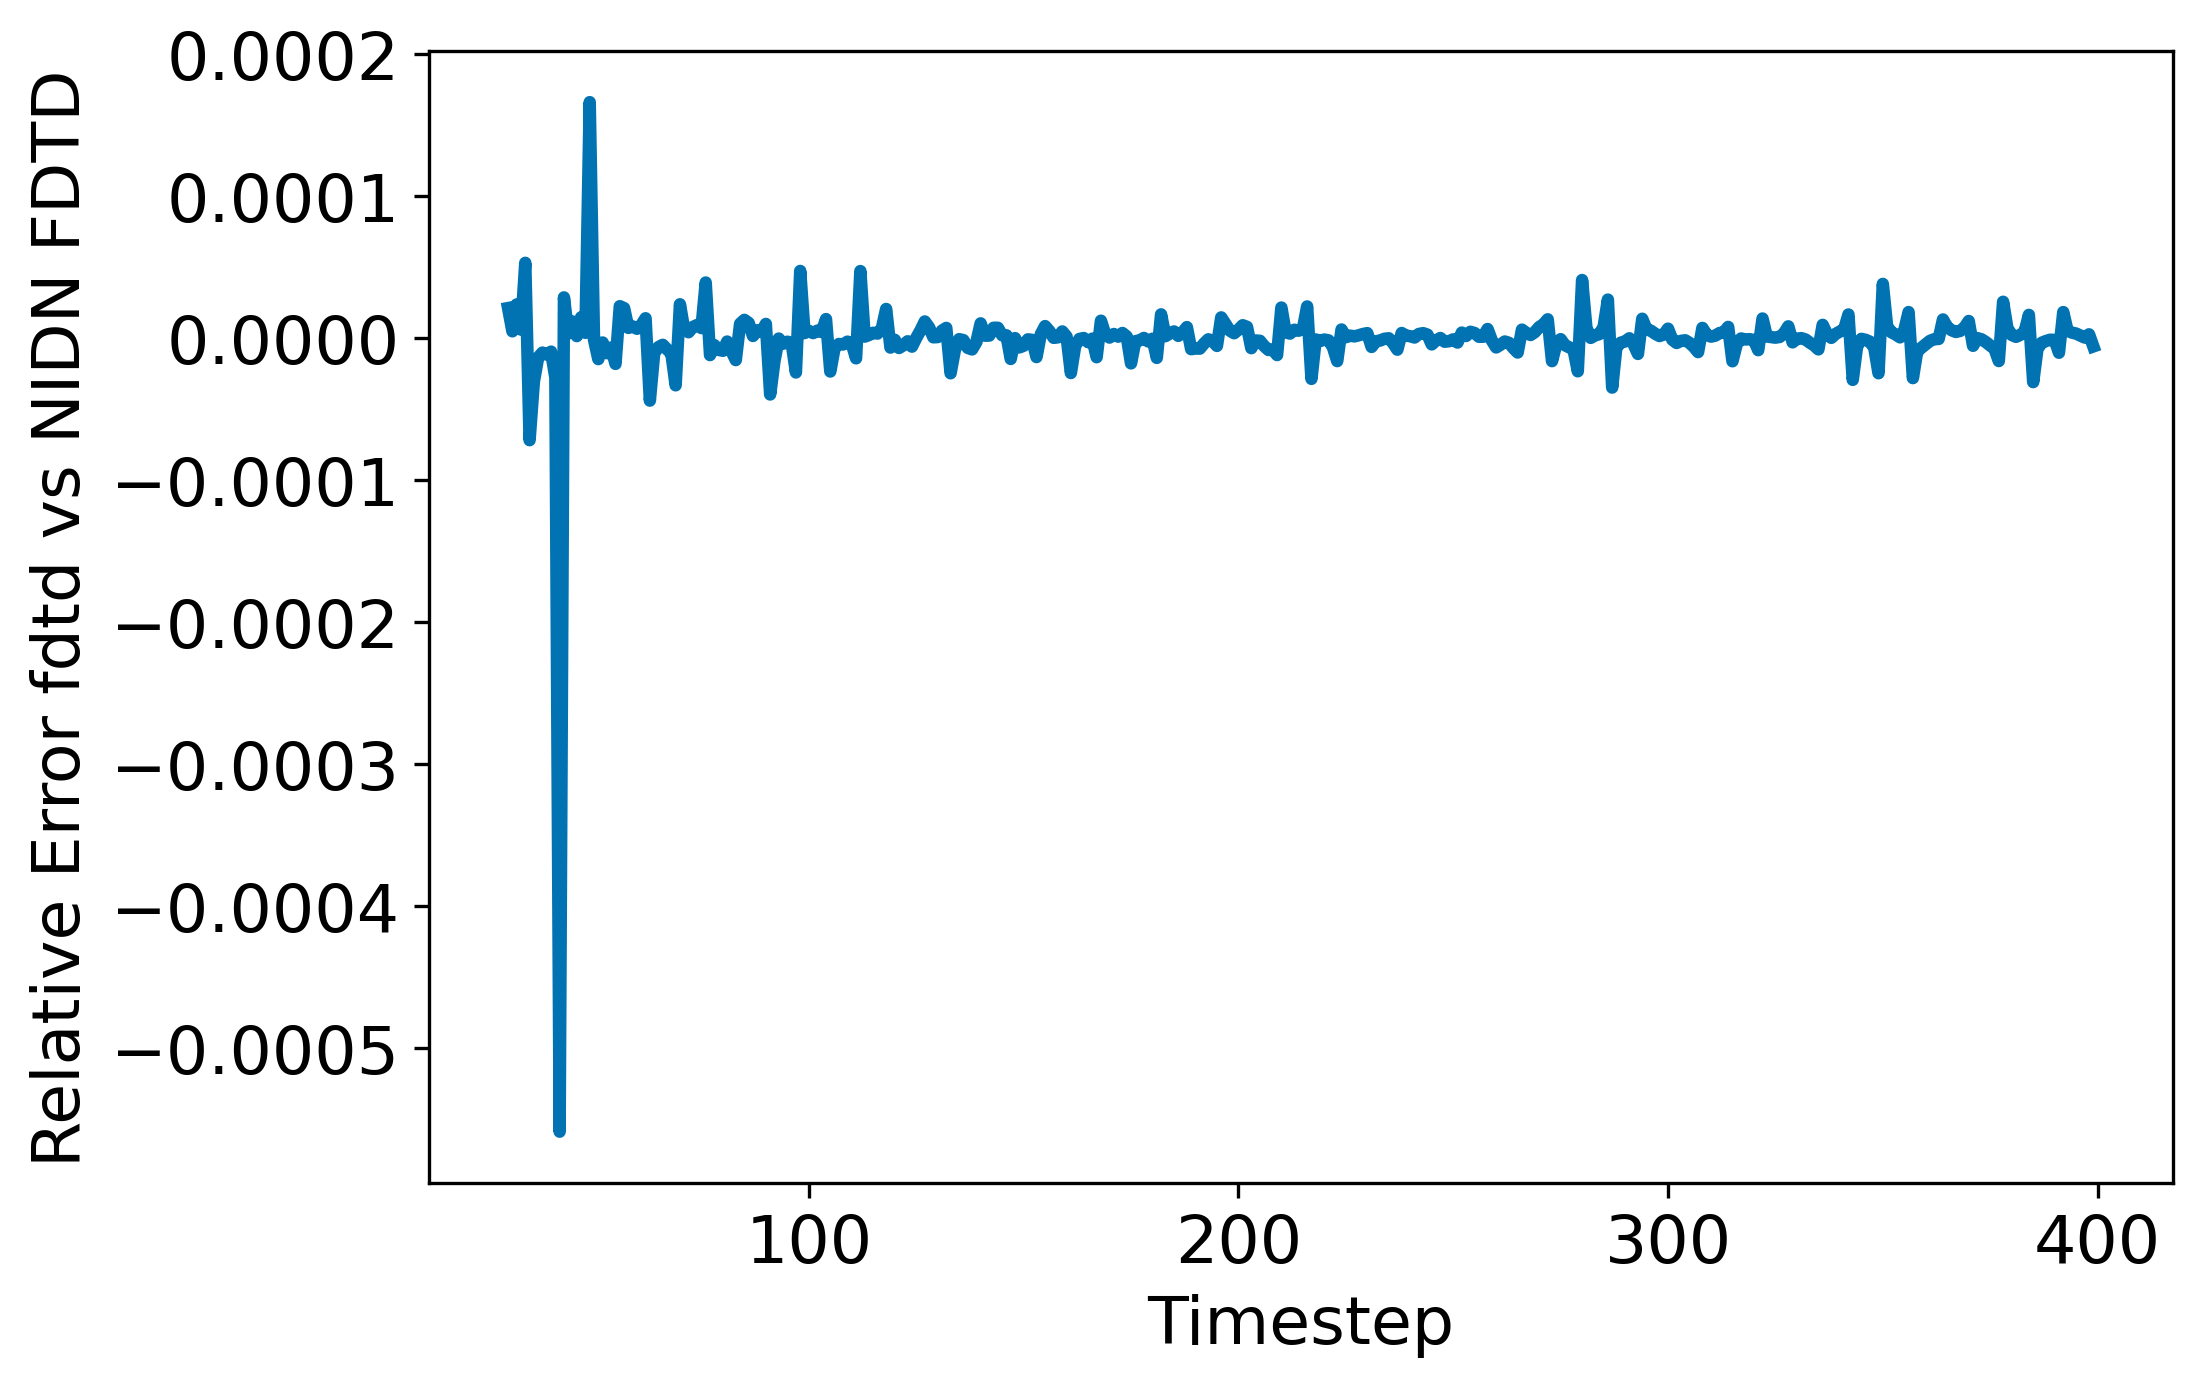

In [17]:
plt.figure(figsize=(7.5,5.0),dpi=300)
plt.plot(t[30:],(torch.abs(torch.tensor(raw_signal)-t_signal_material)/torch.tensor(raw_signal))[30:],c=NIDN_PLOT_COLOR_1,lw=3)
plt.ylabel("Relative Error fdtd vs NIDN FDTD",fontsize=NIDN_FONTSIZE)
plt.xlabel("Timestep",fontsize=NIDN_FONTSIZE)
plt.tick_params(axis="both", which="major", labelsize=NIDN_FONTSIZE)

In [18]:
torch.mean(torch.abs(torch.tensor(raw_signal) - torch.tensor(t_signal_material)))

D:\Temp/ipykernel_13360/163580985.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.mean(torch.abs(torch.tensor(raw_signal) - torch.tensor(t_signal_material)))


tensor(6.8809e-07)